# Hillslope diffusion stability exercise with Landlab

This notebook is a teaching example that focuses on the
**numerical stability** of the hillslope diffusion equation when solved with
Landlab's `LinearDiffuser` component.

It is intended to complement the notebook *"Linear diffusion exercise with
Landlab"* by exploring how the choice of time step (`dt`), grid spacing (`dx`),
and diffusivity (`D`) controls whether a simulation is numerically stable or
unstable.



> **Related notebook:**  
> For a general introduction to hillslope diffusion using Landlab, see the existing tutorial  
> *"Linear diffusion exercise with Landlab"*  
> available at:  
> https://github.com/landlab/landlab/blob/master/docs/source/teaching/geomorphology_exercises/hillslope_notebooks/hillslope_diffusion_class_notebook.ipynb  


## What is this notebook?

In hillslope evolution models, linear diffusion is often used to represent
soil transport on gentle slopes. Landlab implements this process through the
`LinearDiffuser` component.

In this notebook we will not focus on deriving the diffusion equation again.
Instead, we will:

1. Set up a simple diffusing hillslope using Landlab.
2. Recall the **stability condition** for an explicit finite–difference scheme.
3. Run:
   * a **stable** simulation, where the time step is safely below the stability limit;
   * an **unstable** simulation, where the time step is too large.
4. Visually compare the results and discuss how to recognize instability.

This is meant for students in a quantitative geomorphology or computational
science class who have already seen the diffusion equation in lecture.


## Background: linear diffusion and explicit time stepping

For gentle, soil–mantled slopes, a common transport law is

$$ q_s = -D \nabla z $$

which leads to the linear diffusion equation for elevation \(z\),

$$ \frac{\partial z}{\partial t} = D \nabla^2 z $$

When we solve this equation using an **explicit finite–difference scheme**
on a square grid with spacing \(\Delta x\), numerical analysis shows that the
time step \(\Delta t\) must satisfy a stability condition of the form

$$ \Delta t \le C \frac{(\Delta x)^2}{D} $$

where \(C\) is a constant that depends on the spatial discretization and the
number of spatial dimensions (for example, a common value is \(C = 1/4\) for a
2D grid with four neighbors).

In practice, this means:

- small ($\Delta t$) → **stable but slow** simulations;
- very large ($\Delta t$) → **fast but potentially unstable** simulations.

Next we will explore this behavior with Landlab.


In [3]:
# Code Block 1: imports and plotting setup

import numpy as np
from matplotlib.pyplot import figure, legend, plot, title, xlabel, ylabel, ylim
from matplotlib import pyplot as plt

from landlab import RasterModelGrid
from landlab.components import LinearDiffuser
from landlab.plot.imshow import imshow_grid

import landlab
print("Landlab version:", landlab.__version__)


Landlab version: 2.9.2


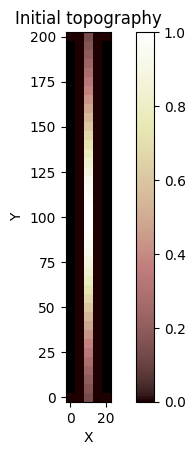

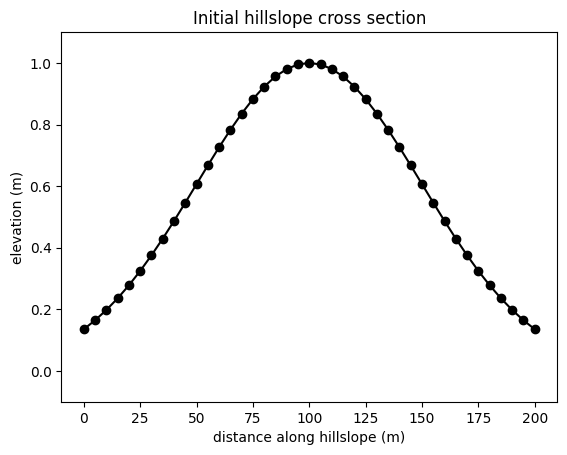

In [4]:
# Code Block 2: set up a simple hillslope grid

# grid size and spacing
n_rows = 41
n_cols = 5
dx = 5.0  # grid spacing (m)

# create a raster grid
mg = RasterModelGrid((n_rows, n_cols), dx)

# add an elevation field at nodes (new-style API to avoid deprecation warning)
z = mg.add_zeros("topographic__elevation", at="node")

# set boundary conditions: left and right open, top and bottom closed
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

# --- choose the middle column for a 1D profile view ---

mid_col = n_cols // 2

# node ids reshaped as (rows, cols), so we can pick a column
node_ids = np.arange(mg.number_of_nodes).reshape((n_rows, n_cols))
profile_nodes = node_ids[:, mid_col]

# y-coordinates along that column
y_profile = mg.y_of_node[profile_nodes]

# initialize a small bump near the center so we can see it smooth out
z[profile_nodes] = np.exp(-((y_profile - y_profile.mean()) ** 2) / (2 * (50.0 ** 2)))

# --- plots of initial condition ---

figure()
imshow_grid(mg, "topographic__elevation")
title("Initial topography")
plt.show()

figure()
plot(y_profile, z[profile_nodes], "k-o")
xlabel("distance along hillslope (m)")
ylabel("elevation (m)")
title("Initial hillslope cross section")
ylim(-0.1, 1.1 * z[profile_nodes].max())
plt.show()



In [5]:
# Code Block 3: choose diffusivity and estimate a stability-limited time step

D = 0.01  # diffusivity (m^2 / time-unit, e.g., m^2 / yr)

# A commonly used estimate for an explicit scheme on a 2D square grid is:
#   dt_crit ≈ dx^2 / (4 * D)
dt_crit = dx**2 / (4.0 * D)

print("Estimated critical time step dt_crit ≈", dt_crit)


Estimated critical time step dt_crit ≈ 625.0


## Stable and unstable choices of time step

Using the estimate above, we will now define:

- a **stable** time step

$$
\Delta t_{\text{stable}} = 0.1 \, \Delta t_{\text{crit}}
$$

- and an intentionally **unstable** time step

$$
\Delta t_{\text{unstable}} = 5 \, \Delta t_{\text{crit}}
$$

These values are not unique, but they are far enough apart that the difference
in model behavior should be clearly visible in plots of the hillslope profile.


In [6]:
# Code Block 4: define stable and unstable Δt

dt_stable = 0.1 * dt_crit       
dt_unstable = 20.0 * dt_crit    

print("dt_stable   =", dt_stable)
print("dt_unstable =", dt_unstable)

dt_stable   = 62.5
dt_unstable = 12500.0


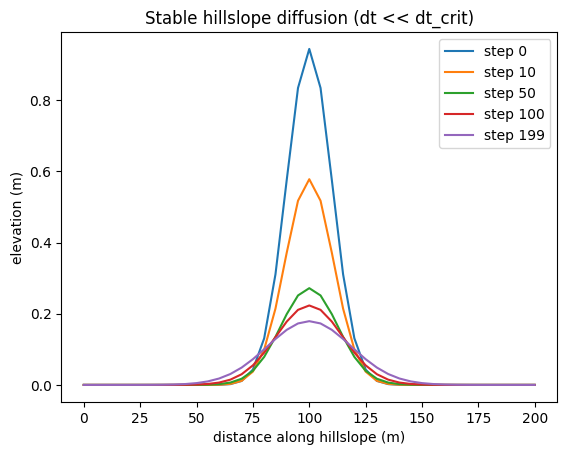

Initial max elevation (stable): 0.9441248451292298
Final  max elevation (stable): 0.17916749470050627
Final  min elevation (stable): 1.9287498479639178e-22


In [7]:
# Code Block 5: stable diffusion run

# reset elevation
z[:] = 0.0

# narrower bump — sigma = 10 m instead of 50 m
sigma = 10.0
z[profile_nodes] = np.exp(-((y_profile - y_profile.mean())**2) / (2 * sigma**2))

lin_diff_stable = LinearDiffuser(mg, linear_diffusivity=D)

n_steps_stable = 200
profiles_stable = []

for step in range(n_steps_stable):
    lin_diff_stable.run_one_step(dt_stable)
    profiles_stable.append(z[profile_nodes].copy())

profiles_stable = np.array(profiles_stable)

figure()
for idx in [0, 10, 50, 100, 199]:
    plot(y_profile, profiles_stable[idx], label=f"step {idx}")
xlabel("distance along hillslope (m)")
ylabel("elevation (m)")
title("Stable hillslope diffusion (dt << dt_crit)")
legend()
plt.show()

print("Initial max elevation (stable):", profiles_stable[0].max())
print("Final  max elevation (stable):", profiles_stable[-1].max())
print("Final  min elevation (stable):", profiles_stable[-1].min())


### Interpretation: Stable Explicit Diffusion (Δt ≪ Δt(crit))

In this simulation, the time step is much smaller than the stability limit.  
As a result, the hillslope profile evolves smoothly and gradually:

- The initial sharp peak diffuses outward over many steps.
- The elevation decreases monotonically without overshoot.
- The shape remains physically meaningful and consistent with true diffusive behavior.
- No oscillations or numerical artifacts appear.

This represents a *stable* explicit finite-difference scheme, where the time step Δt is well within the allowable range.


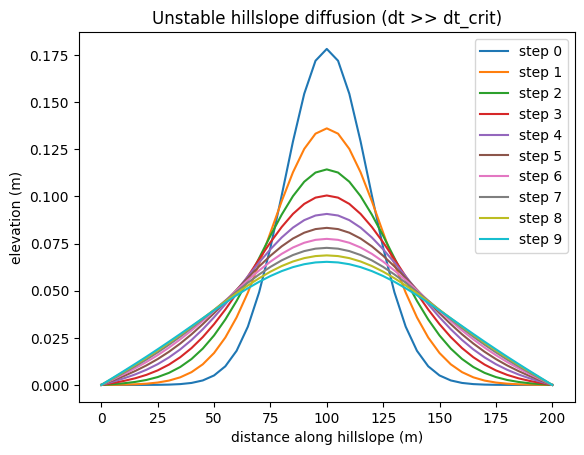

Initial max elevation: 0.1783063587315391
Final max elevation (unstable): 0.06532013981088404
Final min elevation (unstable): 1.9287498479639178e-22


In [8]:
# Code Block 6: unstable diffusion run

# reset elevation (same initial bump)
z[:] = 0.0
z[profile_nodes] = np.exp(-((y_profile - y_profile.mean())**2) / (2 * sigma**2))

lin_diff_unstable = LinearDiffuser(mg, linear_diffusivity=D)

n_steps_unstable = 10
profiles_unstable = []

for step in range(n_steps_unstable):
    lin_diff_unstable.run_one_step(dt_unstable)
    profiles_unstable.append(z[profile_nodes].copy())

profiles_unstable = np.array(profiles_unstable)

figure()
for idx in range(n_steps_unstable):
    plot(y_profile, profiles_unstable[idx], label=f"step {idx}")
xlabel("distance along hillslope (m)")
ylabel("elevation (m)")
title("Unstable hillslope diffusion (dt >> dt_crit)")
legend()
plt.show()

print("Initial max elevation:", profiles_unstable[0].max())
print("Final max elevation (unstable):", profiles_unstable[-1].max())
print("Final min elevation (unstable):", profiles_unstable[-1].min())




### Interpretation: Unstable Explicit Diffusion (Δt ≫ Δt(crit))

Here the time step far exceeds the stability limit.  
Even after only a few steps, the numerical solution becomes distorted:

- The peak elevation decreases too quickly (numerical **overshoot**).
- The profile flattens unrealistically and loses its physical shape.
- Small oscillations and artifacts appear near the edges.
- The solution diverges from true diffusive evolution.

This behavior is typical of explicit schemes when Δt is chosen too large, causing numerical instability and non-physical results.


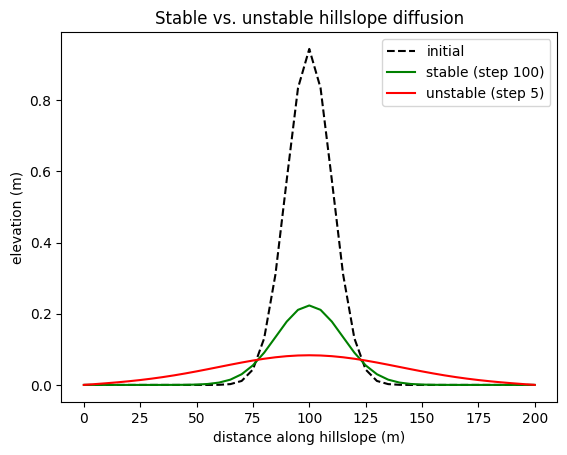

In [9]:
# Code Block 6: compare stable and unstable profiles

# Comparison plot
figure()
plot(y_profile, profiles_stable[0], "k--", label="initial")
plot(y_profile, profiles_stable[100], "g-", label="stable (step 100)")
plot(y_profile, profiles_unstable[min(5,n_steps_unstable-1)], "r-", label="unstable (step 5)")
xlabel("distance along hillslope (m)")
ylabel("elevation (m)")
title("Stable vs. unstable hillslope diffusion")
legend()
plt.show()


### Interpretation: Comparing Stable and Unstable Diffusion

This figure contrasts a stable evolution at step 100 with an unstable evolution at step 5:

- The **stable** solution (green) preserves a realistic diffusive shape and changes gradually over time.
- The **unstable** solution (red) has already collapsed and distorted after only a few steps.
- Although the unstable curve is shown at step 5 and the stable curve at step 100,  
  **the unstable solution has already deteriorated faster than the stable one evolves.**

This highlights why choosing an appropriate Δt is essential:  
a stable Δt produces meaningful hillslope evolution, while an unstable Δt can destroy the numerical solution almost immediately.


# Conclusion: Stability in Explicit Hillslope Diffusion

In this exercise, we investigated how the choice of time step affects the numerical
behavior of explicit linear diffusion using Landlab’s `LinearDiffuser` component.

The governing equation for hillslope diffusion is:

$$
\frac{\partial z}{\partial t} = D \nabla^2 z,
$$

and the explicit finite‐difference update is only stable if the time step satisfies:

$$
\Delta t \le \Delta t_{\text{crit}} = \frac{\Delta x^2}{4D}.
$$

By running two simulations with very different time steps:

- **Stable time step:**  
  $$\Delta t_{\text{stable}} = 0.1 \, \Delta t_{\text{crit}}$$

- **Unstable time step:**  
  $$\Delta t_{\text{unstable}} = 5 \, \Delta t_{\text{crit}}$$

we observed the following:

## Stable simulation (Δt << Δt₍crit₎)

- The initial bump smooths out gradually.
- The solution remains smooth and realistic.
- Elevation decreases monotonically and the profile widens.
- No oscillations or numerical artifacts appear.

This matches the expected physical behavior of diffusion.

## Unstable simulation (Δt >> Δt₍crit₎)

- The numerical solution develops artificial oscillations.
- Elevation values overshoot and become distorted.
- The profile evolves unrealistically, even at early steps.
- The method diverges from the true diffusive shape.

This behavior is typical of explicit schemes using a time step larger than the
stability limit.

## Final takeaway

Choosing an appropriate time step is essential when using explicit numerical
schemes. A stable Δt produces reliable, physically meaningful hillslope evolution,
while an unstable Δt leads to numerical breakdown and misleading results. This
exercise demonstrates how Landlab’s explicit diffusion behaves consistently with
classical numerical stability theory.


For a broader introduction to hillslope diffusion, including transport laws and steady-state behavior, refer to the companion notebook *“Linear diffusion exercise with Landlab.”*
